# Book Recommendation System - EDA Notebook 

This jupyter notebook contains the initial steps of the book recommendation system, where we load our datasets, clean the data and implement the initial processing and feature engineering processes in order to implement effective visualitions and modeling in later steps. 

To begin with, the datasets in their unedited form were acquired through this website, in the datsets section: https://mengtingwan.github.io/data/goodreads.html

For the sake of this project only the following datasets were utilised, and all this data has been scraped from goodreads: 
- goodreads_books.json.gz: Contains detailed information on about 2M books 
- goodreads_book_genres_initial.json.gz: Extracted fuzzy book genres (genre tags are extracted from users' popular shelves by a simple keyword matching process)
- goodreads_interactions.csv: Complete user-book interactions
- book_id_map.csv:Contains user id and book id map

The following markup and code cells will take us through the necessary imports, data loading and dataframe creation steps.

## Necessary Imports for Loading and Pre Processing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import json
import csv
import re 
import pickle

## Loading the Data

In order to load the datasets, we will use a different approach from the typical pd.read_csv() command that we are well acquainted with. The reason for this is because, we have a mix of both json and csv files and because we have very heavy data. 

In this case, we need to use a more scalable and memory efficient technique instead of loading the entire dataset, and that happens to be streaming the data line by line. 

Moreover, it is better to parse through the lines of data and select only the parts that we want to use for our dataset, and in order to implement this effectively, we can use a parsing function. 

In [2]:
# Function to parse through books dataset and retain specific columns
def parse_books(line):
    data = json.loads(line)
    return{
        "book_id": data["book_id"],
        "title": data["title_without_series"],
        "ratings": data["ratings_count"],
        "average_rating": data["average_rating"],
        "url": data["url"],
        "cover_image": data["image_url"],
        "num_pages": data ["num_pages"],
        "publication_year":data["publication_year"],
        "publisher" : data["publisher"],
    }

In [3]:
# stream through books dataset to efficiently load the data 
books_titles = []
with open("goodreads_books.json", 'r') as f:
    while True:
        line = f.readline()
        if not line:
            break
        fields = parse_books(line)
        
        try:
            ratings = int(fields["ratings"])
            
        except ValueError:
            continue
            
        if ratings > 10: #only take into account books with more than 10 
            books_titles.append(fields)

# dictionary to dataframe 
titles = pd.DataFrame.from_dict(books_titles)

In [4]:
titles.head(5) # to initially display the dataset 

,book_id,title,ratings,average_rating,url,cover_image,num_pages,publication_year,publisher
0,7327624,"The Unschooled Wizard (Sun Wolf and Starhawk, ...",140,4.03,https://www.goodreads.com/book/show/7327624-th...,https://images.gr-assets.com/books/1304100136m...,600,1987,"Nelson Doubleday, Inc."
1,6066819,Best Friends Forever,51184,3.49,https://www.goodreads.com/book/show/6066819-be...,https://s.gr-assets.com/assets/nophoto/book/11...,368,2009,Atria Books
2,287140,Runic Astrology: Starcraft and Timekeeping in ...,15,3.40,https://www.goodreads.com/book/show/287140.Run...,https://images.gr-assets.com/books/1413219371m...,,,
3,287141,The Aeneid for Boys and Girls,46,4.13,https://www.goodreads.com/book/show/287141.The...,https://s.gr-assets.com/assets/nophoto/book/11...,162,2006,Yesterday's Classics
4,378460,The Wanting of Levine,12,4.38,https://www.goodreads.com/book/show/378460.The...,https://s.gr-assets.com/assets/nophoto/book/11...,,1979,Berkley Publishing Group


Now, that we have streamed through the very first json file and successfully converted it into a dataframe, we can repeat this process for the other datasets as well. 

In [5]:
#stream through genres dataset 
book_genres = []
with open("goodreads_genres.json", 'r') as f:
    while True:
        line = f.readline()
        if not line:
            break
        fields = json.loads(line)
        book_genres.append(fields)

#dictionary to dataframe        
genres = pd.DataFrame.from_dict(book_genres)

In [6]:
genres.head(5) # to initially display the dataset

,book_id,genres
0,5333265,"{'history, historical fiction, biography': 1}"
1,1333909,"{'fiction': 219, 'history, historical fiction,..."
2,7327624,"{'fantasy, paranormal': 31, 'fiction': 8, 'mys..."
3,6066819,"{'fiction': 555, 'romance': 23, 'mystery, thri..."
4,287140,{'non-fiction': 3}


The genre dataset at first glance can be quite challenging to work with if left this way, so we will be cleaning it in later sections, the next dataset that we need is the bulk of our textual analysis, the reviews dataset.

In [7]:
# Function to parse through reviews dataset and retain specific columns
def parse_reviews(line):
    data = json.loads(line)
    return{
        "user_id": data["user_id"],
        "book_id": data["book_id"],
        "review_id": data["review_id"],
        "rating": data["rating"],
        "review_text": data["review_text"]
    }

In [8]:
#stream through reviews dataset 
book_reviews = []
with open("goodreads_reviews.json", 'r') as f:
    while True:
        line = f.readline()
        if not line:
            break
        fields = json.loads(line)
        book_reviews.append(fields)

#dictionary to dataframe        
reviews = pd.DataFrame.from_dict(book_reviews)

In [9]:
reviews.head(5)

,user_id,book_id,review_id,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments
0,8842281e1d1347389f2ab93d60773d4d,24375664,5cd416f3efc3f944fce4ce2db2290d5e,5,Mind blowingly cool. Best science fiction I've...,Fri Aug 25 13:55:02 -0700 2017,Mon Oct 09 08:55:59 -0700 2017,Sat Oct 07 00:00:00 -0700 2017,Sat Aug 26 00:00:00 -0700 2017,16,0
1,8842281e1d1347389f2ab93d60773d4d,18245960,dfdbb7b0eb5a7e4c26d59a937e2e5feb,5,This is a special book. It started slow for ab...,Sun Jul 30 07:44:10 -0700 2017,Wed Aug 30 00:00:26 -0700 2017,Sat Aug 26 12:05:52 -0700 2017,Tue Aug 15 13:23:18 -0700 2017,28,1
2,8842281e1d1347389f2ab93d60773d4d,6392944,5e212a62bced17b4dbe41150e5bb9037,3,I haven't read a fun mystery book in a while a...,Mon Jul 24 02:48:17 -0700 2017,Sun Jul 30 09:28:03 -0700 2017,Tue Jul 25 00:00:00 -0700 2017,Mon Jul 24 00:00:00 -0700 2017,6,0
3,8842281e1d1347389f2ab93d60773d4d,22078596,fdd13cad0695656be99828cd75d6eb73,4,"Fun, fast paced, and disturbing tale of murder...",Mon Jul 24 02:33:09 -0700 2017,Sun Jul 30 10:23:54 -0700 2017,Sun Jul 30 15:42:05 -0700 2017,Tue Jul 25 00:00:00 -0700 2017,22,4
4,8842281e1d1347389f2ab93d60773d4d,6644782,bd0df91c9d918c0e433b9ab3a9a5c451,4,A fun book that gives you a sense of living in...,Mon Jul 24 02:28:14 -0700 2017,Thu Aug 24 00:07:20 -0700 2017,Sat Aug 05 00:00:00 -0700 2017,Sun Jul 30 00:00:00 -0700 2017,8,0


The above dataset, contains a few columns that we could potentially drop in the next stage, the review_text column here will be most beneficial to perform our text analysis. Apart from these three datasets, we have an interactions dataset that will be imported later onwards while implementing the collaborative filtering aspect of our project.

## Data Preprocessing

This section handles, the cleaning of the data, namely analyzing the columns for data type changes, feature additions, merges, etc. 

We will ensure the changes have been made by viewing info before and after implementing the necessary changes as we see fit for our processing. 

In [10]:
# understanding the titles dataframe 
titles.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1496812 entries, 0 to 1496811
Data columns (total 9 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   book_id           1496812 non-null  object
 1   title             1496812 non-null  object
 2   ratings           1496812 non-null  object
 3   average_rating    1496812 non-null  object
 4   url               1496812 non-null  object
 5   cover_image       1496812 non-null  object
 6   num_pages         1496812 non-null  object
 7   publication_year  1496812 non-null  object
 8   publisher         1496812 non-null  object
dtypes: object(9)
memory usage: 102.8+ MB


As we can see from the above command, the titles dataframe contains a total of 8 columns that are all string types and have no missing values, however, it is evident that because we converted the json files into a dictionary and then to a dataframe that there may be hidden missing values in the form of whitespaces. 

Changes to titles dataframe: 
- Ensure 'ratings' column is numeric 
- Crete a separate modified title for ease to search 
- Ensure 'average_rating' is a float number 
- Ensure 'num_pages' is an int number 
- Ensure 'publication_year' is a date-time year 
- Fill in the hidden missing values appropriately

In [11]:
#data cleaning for titles dataframe

#ensure ratings column is numeric 
titles['ratings']= pd.to_numeric(titles['ratings'])

#ensure book title is stripped of spaces, lower case, and lacks special chars
titles['mod_title'] = titles['title'].str.replace("[^a-zA-Z0-9 ]", "", regex=True)
titles['mod_title'] = titles['title'].str.replace("\s+", " ", regex = True)
titles['mod_title'] = titles['title'].str.lower()
titles = titles[titles['mod_title'].str.len()>0]

#ensure average_rating column is a float 
titles['average_rating'] = titles['average_rating'].astype(float)

#ensure num_pages column is an int number, and fill any missing values with 150 pages 
titles['num_pages'] = titles['num_pages'].replace(r'^\s*$', np.nan, regex=True)
titles['num_pages'] = titles['num_pages'].astype(pd.Int64Dtype())
titles['num_pages'] = titles['num_pages'].fillna(150)

#ensure publisher column is not empty 
titles['publisher'] = titles['publisher'].replace(r'^\s*$', np.nan, regex=True)
titles['publisher'] = titles['publisher'].fillna("Unknown")

#ensure publication year is a date time year and not empty 
titles['publication_year'] = titles['publication_year'].str.strip()  # Remove leading/trailing spaces
titles['publication_year'] = pd.to_datetime(titles['publication_year'], format='%Y', errors='coerce')
most_common_year = titles['publication_year'].mode()[0]  # Get the most common year
titles['publication_year'].fillna(most_common_year, inplace=True)
titles['publication_year'] = titles['publication_year'].dt.year
# Drop rows where 'publication_year' is greater than 2023
titles = titles[titles['publication_year'] <= 2023]


In [12]:
# verify the new info 
titles.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1496730 entries, 0 to 1496811
Data columns (total 10 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   book_id           1496730 non-null  object 
 1   title             1496730 non-null  object 
 2   ratings           1496730 non-null  int64  
 3   average_rating    1496730 non-null  float64
 4   url               1496730 non-null  object 
 5   cover_image       1496730 non-null  object 
 6   num_pages         1496730 non-null  Int64  
 7   publication_year  1496730 non-null  int32  
 8   publisher         1496730 non-null  object 
 9   mod_title         1496730 non-null  object 
dtypes: Int64(1), float64(1), int32(1), int64(1), object(6)
memory usage: 121.3+ MB


In [13]:
#view the modified dataframe 
titles.head(5)

,book_id,title,ratings,average_rating,url,cover_image,num_pages,publication_year,publisher,mod_title
0,7327624,"The Unschooled Wizard (Sun Wolf and Starhawk, ...",140,4.03,https://www.goodreads.com/book/show/7327624-th...,https://images.gr-assets.com/books/1304100136m...,600,1987,"Nelson Doubleday, Inc.","the unschooled wizard (sun wolf and starhawk, ..."
1,6066819,Best Friends Forever,51184,3.49,https://www.goodreads.com/book/show/6066819-be...,https://s.gr-assets.com/assets/nophoto/book/11...,368,2009,Atria Books,best friends forever
2,287140,Runic Astrology: Starcraft and Timekeeping in ...,15,3.40,https://www.goodreads.com/book/show/287140.Run...,https://images.gr-assets.com/books/1413219371m...,150,2013,Unknown,runic astrology: starcraft and timekeeping in ...
3,287141,The Aeneid for Boys and Girls,46,4.13,https://www.goodreads.com/book/show/287141.The...,https://s.gr-assets.com/assets/nophoto/book/11...,162,2006,Yesterday's Classics,the aeneid for boys and girls
4,378460,The Wanting of Levine,12,4.38,https://www.goodreads.com/book/show/378460.The...,https://s.gr-assets.com/assets/nophoto/book/11...,150,1979,Berkley Publishing Group,the wanting of levine


In [14]:
# understanding the genres dataframe 
genres.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2360655 entries, 0 to 2360654
Data columns (total 2 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   book_id  object
 1   genres   object
dtypes: object(2)
memory usage: 36.0+ MB


As we can see from the above command, the genres dataframe contains a total of 2 columns that are all string types and have no missing values, however, it is evident that because we converted the json files into a dictionary and then to a dataframe that there may be hidden missing values in the form of whitespaces.

Changes to be made: 
The primary change would be to extract the list of comma separated genres and turn them into boolean features for each book_id, so that this dataset can be merged with the titles dataset in order to keep only the necessary values. 

In [15]:
# create a list of book ids that we need to retain in the genres dataframe
book_list = titles['book_id'].tolist()
genres = genres[genres['book_id'].isin(book_list)]

In [16]:
# Create a new DataFrame with a copy of 'genres'
cleaned_genres = genres.copy()

# Create a new column 'cleaned_genres' with a more human-readable format
cleaned_genres['cleaned_genres'] = genres['genres'].apply(lambda x: ', '.join([f'{key} ({value})' for key, value in x.items()]))

# Drop the original 'genres' column from the new DataFrame
cleaned_genres = cleaned_genres.drop(columns=['genres'])

# Define a function to remove numbers in brackets from a string
def remove_numbers_in_brackets(text):
    return re.sub(r'[-+]?\d+', '', text).replace('()', '')

# Apply the function to the 'cleaned_genres' column
cleaned_genres['cleaned_genres'] = cleaned_genres['cleaned_genres'].apply(remove_numbers_in_brackets)

# Split the 'cleaned_genres' column by commas and create a list of all unique genres
all_genres = cleaned_genres['cleaned_genres'].str.split(', ').explode().unique()

# Create new columns for each unique genre
for genre in all_genres:
    cleaned_genres[genre] = cleaned_genres['cleaned_genres'].str.contains(genre, case=False, regex=False)

# Drop the original 'cleaned_genres' column
cleaned_genres = cleaned_genres.drop(columns=['cleaned_genres'])

# Drop the final column 
cleaned_genres = cleaned_genres.drop(cleaned_genres.columns[17], axis=1)

#verify the new info 
cleaned_genres.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1496730 entries, 2 to 2360653
Data columns (total 17 columns):
 #   Column              Non-Null Count    Dtype 
---  ------              --------------    ----- 
 0   book_id             1496730 non-null  object
 1   fantasy             1496730 non-null  bool  
 2   paranormal          1496730 non-null  bool  
 3   fiction             1496730 non-null  bool  
 4   mystery             1496730 non-null  bool  
 5   thriller            1496730 non-null  bool  
 6   crime               1496730 non-null  bool  
 7   poetry              1496730 non-null  bool  
 8   romance             1496730 non-null  bool  
 9   non-fiction         1496730 non-null  bool  
 10  history             1496730 non-null  bool  
 11  historical fiction  1496730 non-null  bool  
 12  biography           1496730 non-null  bool  
 13  children            1496730 non-null  bool  
 14  young-adult         1496730 non-null  bool  
 15  comics              1496730 non-null 

In [17]:
#view the dataframe
cleaned_genres.head(5) 

,book_id,fantasy,paranormal,fiction,mystery,thriller,crime,poetry,romance,non-fiction,history,historical fiction,biography,children,young-adult,comics,graphic
2,7327624,True,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False
3,6066819,False,False,True,True,True,True,False,True,False,False,False,False,False,False,False,False
4,287140,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False
5,287141,True,True,True,False,False,False,False,False,False,True,True,True,True,True,False,False
6,378460,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False


In [18]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15739967 entries, 0 to 15739966
Data columns (total 11 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   user_id       object
 1   book_id       object
 2   review_id     object
 3   rating        int64 
 4   review_text   object
 5   date_added    object
 6   date_updated  object
 7   read_at       object
 8   started_at    object
 9   n_votes       int64 
 10  n_comments    int64 
dtypes: int64(3), object(8)
memory usage: 1.3+ GB


As we can see above, the info method shows us that we have 11 columns in this dataset, out of which we need only the first 5 - user_id, book_id, review_id, rating and review_text. Moreover, we need to ensure that the dataset contains only the book_id from our main titles dataset. Finally, we need to create a new feature in order to better predict the high rating using logistic regression, that will be the count of review texts per book, in the titles dataset.

In [19]:
#use the book_list to keeo only the matching rows in the reviews dataset
reviews = reviews[reviews['book_id'].isin(book_list)]

In [20]:
#cleaning the reviews dataset 
#Find the index of the 'review_text' column
review_text_index = reviews.columns.get_loc('review_text')
#Drop columns after the 'review_text' column
reviews = reviews.iloc[:, :review_text_index + 1]
#Feature Creation
titles['text_review_count'] = reviews.groupby('book_id')['review_text'].transform('count')

In [21]:
#ensure there are no NaN values in the text_review_count column 
titles['text_review_count'].isnull().sum()
titles['text_review_count'].fillna(0, inplace=True)

In [22]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14972821 entries, 0 to 15739966
Data columns (total 5 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   user_id      object
 1   book_id      object
 2   review_id    object
 3   rating       int64 
 4   review_text  object
dtypes: int64(1), object(4)
memory usage: 1.2+ GB


In [23]:
reviews.head(5)

,user_id,book_id,review_id,rating,review_text
0,8842281e1d1347389f2ab93d60773d4d,24375664,5cd416f3efc3f944fce4ce2db2290d5e,5,Mind blowingly cool. Best science fiction I've...
1,8842281e1d1347389f2ab93d60773d4d,18245960,dfdbb7b0eb5a7e4c26d59a937e2e5feb,5,This is a special book. It started slow for ab...
2,8842281e1d1347389f2ab93d60773d4d,6392944,5e212a62bced17b4dbe41150e5bb9037,3,I haven't read a fun mystery book in a while a...
3,8842281e1d1347389f2ab93d60773d4d,22078596,fdd13cad0695656be99828cd75d6eb73,4,"Fun, fast paced, and disturbing tale of murder..."
4,8842281e1d1347389f2ab93d60773d4d,6644782,bd0df91c9d918c0e433b9ab3a9a5c451,4,A fun book that gives you a sense of living in...


In [24]:
titles.head()

,book_id,title,ratings,average_rating,url,cover_image,num_pages,publication_year,publisher,mod_title,text_review_count
0,7327624,"The Unschooled Wizard (Sun Wolf and Starhawk, ...",140,4.03,https://www.goodreads.com/book/show/7327624-th...,https://images.gr-assets.com/books/1304100136m...,600,1987,"Nelson Doubleday, Inc.","the unschooled wizard (sun wolf and starhawk, ...",25.0
1,6066819,Best Friends Forever,51184,3.49,https://www.goodreads.com/book/show/6066819-be...,https://s.gr-assets.com/assets/nophoto/book/11...,368,2009,Atria Books,best friends forever,80.0
2,287140,Runic Astrology: Starcraft and Timekeeping in ...,15,3.40,https://www.goodreads.com/book/show/287140.Run...,https://images.gr-assets.com/books/1413219371m...,150,2013,Unknown,runic astrology: starcraft and timekeeping in ...,5.0
3,287141,The Aeneid for Boys and Girls,46,4.13,https://www.goodreads.com/book/show/287141.The...,https://s.gr-assets.com/assets/nophoto/book/11...,162,2006,Yesterday's Classics,the aeneid for boys and girls,7.0
4,378460,The Wanting of Levine,12,4.38,https://www.goodreads.com/book/show/378460.The...,https://s.gr-assets.com/assets/nophoto/book/11...,150,1979,Berkley Publishing Group,the wanting of levine,3.0


The main datasets for the analysis have been cleaned and prepared accordingly, now we can move onto the initial questions and visualizations to guide us through this project. 

## Data Analysis and Visualization

Upon completion of the preprocessing stage, we have two ready datasets, namely titles and cleaned_genres which can be merged on book_id as the key column. Now, we are at a stage where we can begin asking some questions related to the business context of our data. 

Since, we are working with book related data, the primary stakeholders involved would be, publishers, authors and the reading community. 

While cleaning the data, the following questions were brainstormed:

### Question 1: What is the distribution of average ratings for books? 

/Users/macbook/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/macbook/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


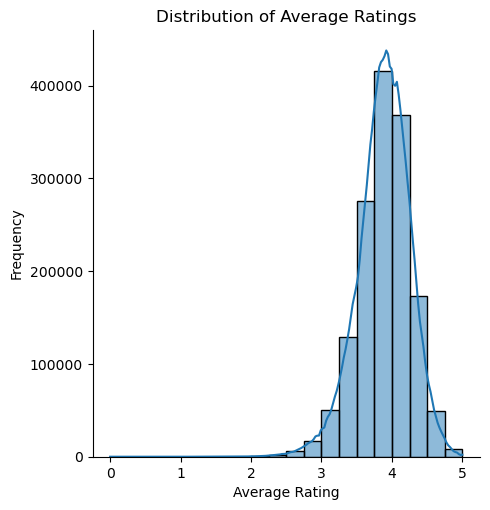

In [25]:
#make a histogram with probability distribution 
sns.displot(titles['average_rating'], kde=True, bins = 20)
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Average Ratings')
plt.show()

The above kde distribution shows us that the majority of the books have an average rating in the 3.75 to 4 stars range. The distribution has a left or negative skew and a higher kurtosis or peak as well which may indicate that the majority of values for ratings are smaller and the distribution has outliers on the lower end of the scale.

### Question 2: How are the average ratings of books distributed by publication year 2000 onwards?



/Users/macbook/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/macbook/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/macbook/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0.5, 1.0, 'Average Ratings of Books Published from 2000')

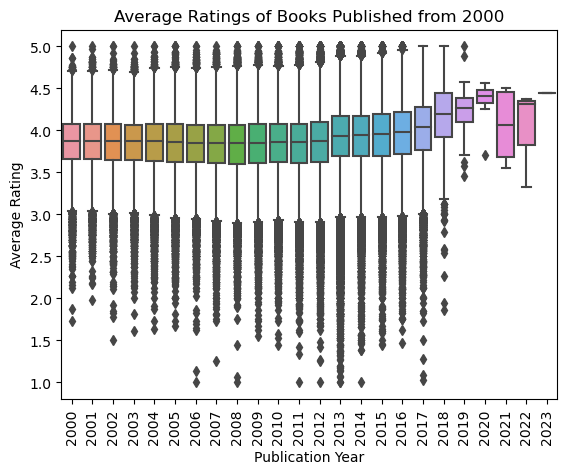

In [26]:
# Filter the dataset for books published between 2000 and 2023
filtered_titles = titles[(titles['publication_year'] >= 2000)]

# Create a box plot to visualize the distribution of average ratings by publication year
sns.boxplot(x='publication_year', y='average_rating', data=filtered_titles)
plt.xticks(rotation=90)
plt.xlabel('Publication Year')
plt.ylabel('Average Rating')
plt.title('Average Ratings of Books Published from 2000')

The above boxplot visualizations show us a distribution of the average ratings of the books published since the year 2000. We can see the summary statistics for each year, and it can be noted that the highest median value within this range can be found in the year 2020, if we do not take into account the sole book published in 2023. We can also infer that a majority of the outliers have a rating below 3 stars. 

### Question 3: Is there a correlation between the number of pages and average ratings of books?

/Users/macbook/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/macbook/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/macbook/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/macbook/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values

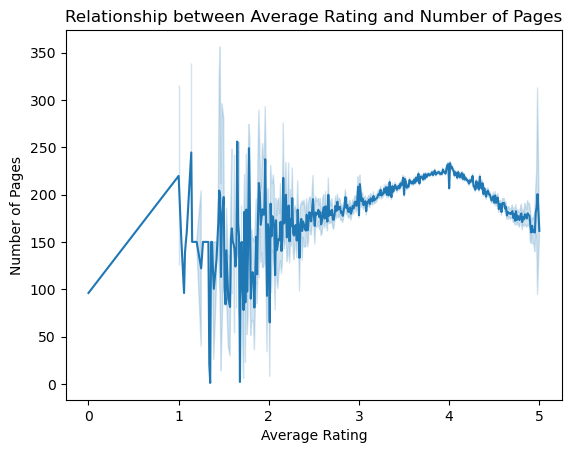

In [27]:
#filter the data to take into consideration books with upto 500 pages
filtered_titles = titles[(titles['num_pages']<500)]
#create a lineplot to display the trend 
sns.lineplot(x='average_rating', y='num_pages', data=filtered_titles)
plt.xlabel('Average Rating')
plt.ylabel('Number of Pages')
plt.title('Relationship between Average Rating and Number of Pages')
plt.show()

The above lineplot provides us with the following insights: 
- Volatility in Lower Ratings: There is a high level of volatility in the number of pages for books with lower average ratings (from 0 to around 2). The error bars or confidence intervals are quite large in this section, indicating a wide variance in the number of pages for books with lower ratings.

- Stabilization in Mid to High Ratings: As the average rating increases (approximately from 2 to 4.5), the graph becomes more stable, and the confidence intervals/error bars become narrower. This suggests that there is less variance in the number of pages for books with higher ratings.

- Decrease in Number of Pages for Highest Ratings: There appears to be a slight decline in the number of pages as the rating approaches 5. This could indicate that books with the highest ratings do not necessarily have a high number of pages.

### Question 4: What are the most common genres in the dataset, and how do they correlate with user ratings?

/Users/macbook/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/macbook/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/macbook/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


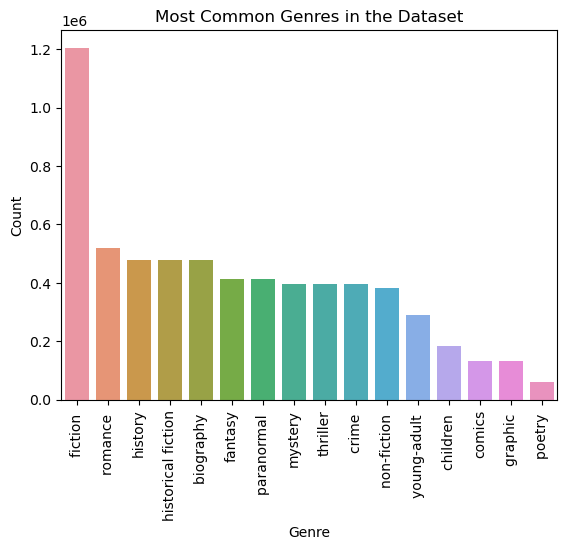

In [28]:
#use the cleaned_genres dataset
common_genres = cleaned_genres.iloc[:, 1:].sum().sort_values(ascending=False)
sns.barplot(x=common_genres.index, y=common_genres.values)
plt.xlabel('Genre')
plt.ylabel('Count')
plt.title('Most Common Genres in the Dataset')
plt.xticks(rotation=90)
plt.show()

The above barplot indicates that the fiction genre has an exponentially greater frequency within the books that we have in our dataset, whereas poetry seems to be the least. The romance, history , historical fiction and biography genres are around a similar range, on the higher end and then the lower end constitutes of graphic, comicd, children and young adult books. 

### Question 5: Which publishers have the most highly-rated books in the dataset?

/Users/macbook/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/macbook/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/macbook/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


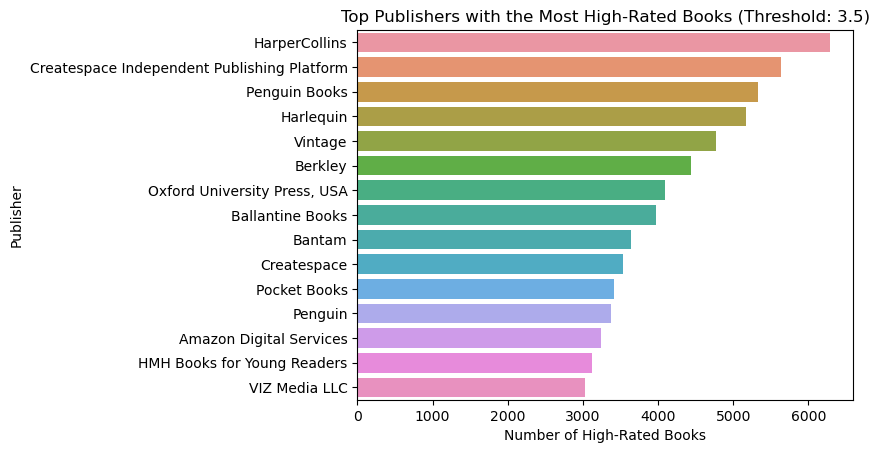

In [29]:
# Define the threshold for high-rated books (you can adjust this value)
threshold_rating = 3.5

# Filter titles for books with an average rating above the threshold and with a known publisher
high_rated_books = titles[(titles['average_rating'] >= threshold_rating) & (titles['publisher'] != 'Unknown')]

# Group by publisher and count the number of high-rated books for each publisher
high_rated_counts = high_rated_books['publisher'].value_counts()

# Display the top publishers with the most high-rated books
top_publishers_high_rated = high_rated_counts.head(15)  # Change the number to display more or fewer publishers

# Create a bar plot to visualize the top publishers with the most high-rated books
sns.barplot(x=top_publishers_high_rated.values, y=top_publishers_high_rated.index)
plt.xlabel('Number of High-Rated Books')
plt.ylabel('Publisher')
plt.title(f'Top Publishers with the Most High-Rated Books (Threshold: {threshold_rating})')
plt.show()

The above horizontal barplot indicates that HarperCollins has published the most high rated books with an average rating equal to greater than 3.5, ranging to over 6000 books, whereas VIZ Media LLC seems to have published the least, about 3000 books. 

### Question 6: How many books have unknown publisher information?

In [30]:
# Count the number of books with 'Unknown' publisher
unknown_publisher_count = titles[titles['publisher'] == 'Unknown'].shape[0]

# Display the count as text
print(f"Number of Books with Unknown Publisher: {unknown_publisher_count}")

Number of Books with Unknown Publisher: 403628


### Question 7: What are the top 10 highest reviewed books? 

Top 10 Most Reviewed Books:
The Fault in Our Stars: 20756 reviews
The Hunger Games (The Hunger Games, #1): 18617 reviews
Mockingjay (The Hunger Games, #3): 13536 reviews
The Girl on the Train: 13402 reviews
Catching Fire (The Hunger Games, #2): 11904 reviews
The Book Thief: 11300 reviews
Fifty Shades of Grey (Fifty Shades, #1): 11184 reviews
Divergent (Divergent, #1): 10743 reviews
Twilight (Twilight, #1): 10535 reviews
The Martian: 9590 reviews


/Users/macbook/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/macbook/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/macbook/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


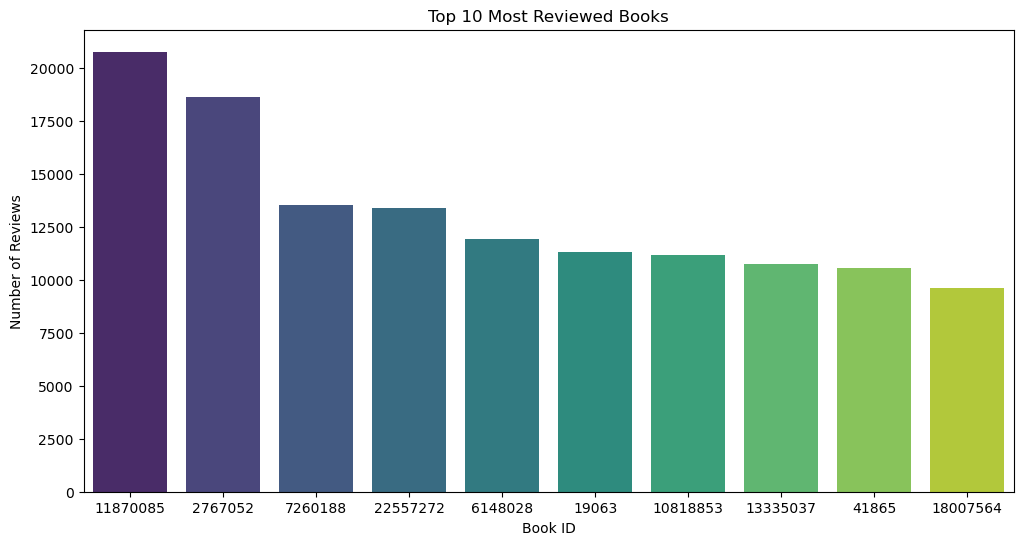

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Group the reviews dataset by 'book_id' and calculate the count of reviews for each book
reviews_count = reviews['book_id'].value_counts()

# Get the top 10 most reviewed books
top_10_most_reviewed_books = reviews_count.head(10)

# Display the top 10 most reviewed books
print("Top 10 Most Reviewed Books:")
for book_id, reviews_count in top_10_most_reviewed_books.items():
    book_title = titles.loc[titles['book_id'] == book_id, 'title'].values[0]
    print(f"{book_title}: {reviews_count} reviews")

# Create a bar plot to visualize the number of reviews for each book
plt.figure(figsize=(12, 6))
sns.barplot(x=top_10_most_reviewed_books.index, y=top_10_most_reviewed_books.values, palette='viridis')
plt.xlabel('Book ID')
plt.ylabel('Number of Reviews')
plt.title('Top 10 Most Reviewed Books')
plt.show()

The above plot shows us the top 10 most reviewed books in order: 
- The Fault in Our Stars: 20756 reviews
- The Hunger Games (The Hunger Games, #1): 18617 reviews
- Mockingjay (The Hunger Games, #3): 13536 reviews
- The Girl on the Train: 13402 reviews
- Catching Fire (The Hunger Games, #2): 11904 reviews
- The Book Thief: 11300 reviews
- Fifty Shades of Grey (Fifty Shades, #1): 11184 reviews
- Divergent (Divergent, #1): 10743 reviews
- Twilight (Twilight, #1): 10535 reviews
- The Martian: 9590 reviews

### Question 8: What is the genre distribution for the most highly reviewed books?

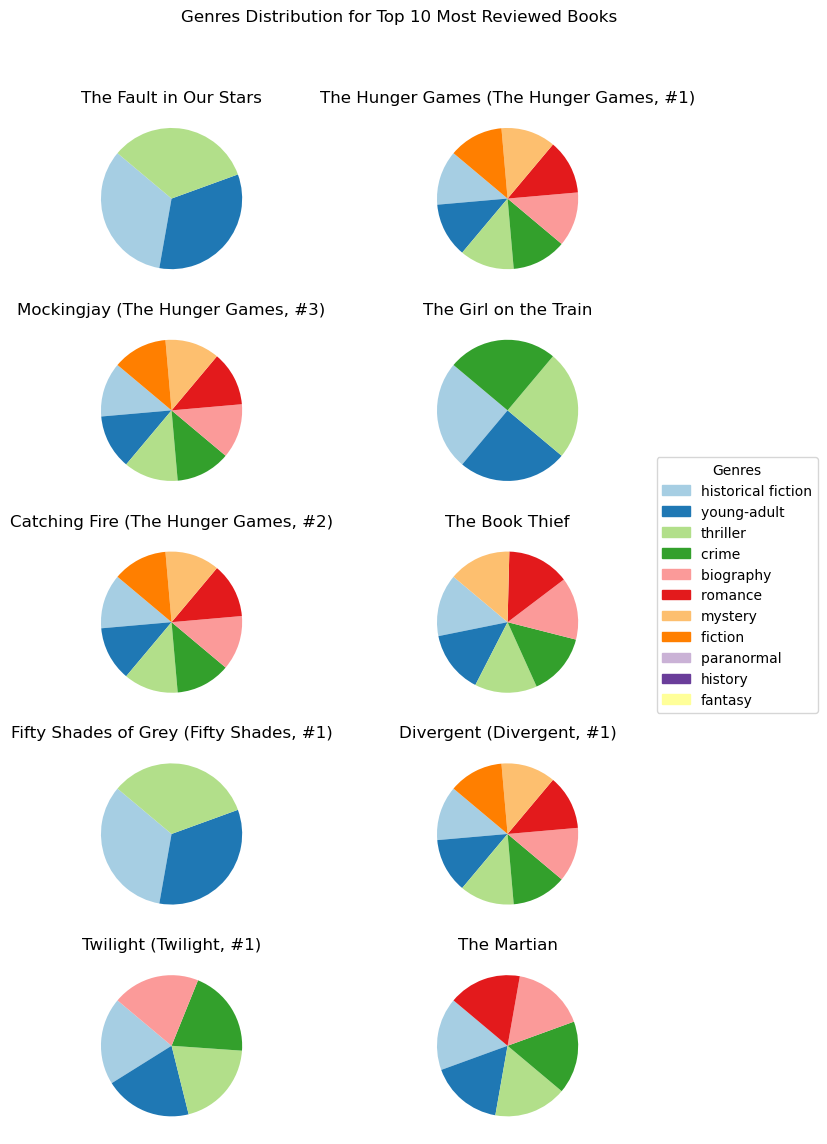

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

# Group the reviews dataset by 'book_id' and calculate the count of reviews for each book
reviews_count = reviews['book_id'].value_counts()

# Get the top 10 most reviewed books
top_10_most_reviewed_books = reviews_count.head(10)

# Assuming you have a genres dataset with columns 'book_id', 'fantasy', 'paranormal', 'fiction', ...
# Let's call this dataset 'cleaned_genres'

# Join the titles dataset with the genres dataset to get the genres information
top_10_most_reviewed_books_genres = pd.merge(top_10_most_reviewed_books.reset_index(), cleaned_genres, left_on='book_id', right_on='book_id', how='left')

# Set up colors for genres using the 'tab10' color map
genre_colors = plt.cm.Paired(np.arange(len(cleaned_genres.columns[1:])))

# Display the top 10 most reviewed books and their genres in a 5x2 grid with a single legend
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 12))
fig.suptitle('Genres Distribution for Top 10 Most Reviewed Books')

# Initialize a set to track unique legend labels
unique_legend_labels = set()

for i, (ax, (_, row)) in enumerate(zip(axes.flatten(), top_10_most_reviewed_books_genres.iterrows())):
    book_id, book_title = row['book_id'], titles.loc[titles['book_id'] == row['book_id'], 'title'].values[0]
    book_genres = [genre for genre in cleaned_genres.columns[1:] if row[genre]]

    # Plot a pie chart for each book's genres without autopct
    wedges, _ = ax.pie([1] * len(book_genres), startangle=140, colors=genre_colors)
    ax.set_title(book_title)

    # Add genres to the set for the legend
    unique_legend_labels.update(book_genres)

# Create proxy artists for the legend
legend_handles = [Patch(color=color, label=label) for color, label in zip(genre_colors, unique_legend_labels)]

# Create a single legend for all the unique genres with reduced spacing
fig.legend(handles=legend_handles, title='Genres', loc='center left', bbox_to_anchor=(0.75, 0.5), fancybox=True, borderaxespad=0.5)

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 0.88, 0.95])

# Show the plots
plt.show()

The above questions and visulalizations provide us an initial yet holistic view of the data that we are dealing with. The following section will include a further analysis through the use of ML models. 

## Data Modeling 

This section of our notebook handles the fundamental processing of our data and the actual implementation of our book recommender system. Here we will be implmenting and testing the best fitting models for our recommender. 

We have selected the following models for implementation in this section:
- Logistic Regression based on genres to determine if 3.5 is the average rating for books
- Text analysis using TF-IDF matrix for search functionality 
- Collaborative Filtering to build recommender 


Moreover, in order to determine how well these models work, we have chosen to use the following metrics as well:

1. Logistic Regression
    - Accuracy 
    - Precision 
    - Confusion Matrix
    - Summary Statistics
2. Text analysis using TF-IDF 
    - Similarity Score 
    - Domain Knowledge
3. Collaborative filtering for recommendations 
    - Similarity Score 
    - Matrix operations 
    - Domain Knowledge

### Necessary Imports for Modeling 

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import coo_matrix

### 1. Logistic Regression based on genres to determine 3.5 is average rating for a book

In [34]:
# USING SCIKIT LEARN
# Set the threshold for 'average_rating' to classify as high or low
threshold = 3.5

# Remove extra spaces at the end of column names
cleaned_genres.columns = cleaned_genres.columns.str.strip()

# Merge the datasets on 'book_id'
merged_data = pd.merge(cleaned_genres, titles[['book_id', 'text_review_count', 'average_rating']], on='book_id', how='inner')

# Create a binary outcome variable indicating high or low rating
merged_data['high_rating'] = (merged_data['average_rating'] >= threshold).astype(int)

# Select features for the logistic regression model
X = merged_data[['average_rating','text_review_count','fantasy', 'paranormal', 'fiction', 'mystery', 'thriller', 'crime',
                 'poetry', 'romance', 'non-fiction', 'history', 'historical fiction',
                 'biography', 'children', 'young-adult', 'comics', 'graphic']]

# Target variable
Y = merged_data['high_rating']

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=101)

# Build the logistic regression model
model = LogisticRegression(max_iter=1000)  # Increase max_iter to 1000 or higher

# Train the model
model.fit(X_train, Y_train)

# Make predictions
predictions = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(Y_test, predictions)
print(f"Accuracy: {accuracy}")

# Additional evaluation metrics
print(classification_report(Y_test, predictions, zero_division = 1))
print(confusion_matrix(Y_test, predictions))

Accuracy: 0.9997928818156916
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     61853
           1       1.00      1.00      1.00    387166

    accuracy                           1.00    449019
   macro avg       1.00      1.00      1.00    449019
weighted avg       1.00      1.00      1.00    449019

[[ 61760     93]
 [     0 387166]]


### 2. Text analysis for search functionality 

In [35]:
# adding clickable feature to links 
def make_clickable(val):
    return '<a target="_blank" href="{}">Goodreads</a>'.format(val)
def show_image(val):
    return '<img src ="{}" width=50></img>'.format(val)

In [36]:
#This is to store our titles dataset in order to implement the web app 
pickle.dump(titles, open('titles.pkl', 'wb'))

In [37]:
# Building a book Search Engine for the Recommender 
vectorizer = TfidfVectorizer()
Tfidf = vectorizer.fit_transform(titles['mod_title'])

#return the 5 most similar to the title 
def search(query, vectorizer):
    processed = re.sub("[^a-zA-Z0-9 ]", "", query.lower())
    query_vec = vectorizer.transform([processed])
    similarity = cosine_similarity(query_vec, Tfidf).flatten()
    indices = np.argpartition(similarity, -10)[-10:]
    results = titles.iloc[indices]
    results = results.sort_values('ratings', ascending = False)
    return results.head(3).style.format({'url': make_clickable, 'cover_image': show_image})

In [38]:
#example usage for search query 
search("the hunger games", vectorizer)

,book_id,title,ratings,average_rating,url,cover_image,num_pages,publication_year,publisher,mod_title,text_review_count
649980,6053292,"The Hunger Games (The Hunger Games, #1)",7425,4.340000,Goodreads,,436,2009,Scholastic,"the hunger games (the hunger games, #1)",3.000000
1293048,7107665,"The Hunger Games (The Hunger Games, #1)",5426,4.340000,Goodreads,,358,2009,Scholastic,"the hunger games (the hunger games, #1)",895.000000
1458109,7077211,"The Hunger Games (The Hunger Games, #1)",1016,4.340000,Goodreads,,408,2009,Gramedia Pustaka Utama,"the hunger games (the hunger games, #1)",4.000000


### 3. Collaborative filtering for the recommender 

In [40]:
# In order to proceed with this part, we created a personal list of liked books 
# import the liked list 

my_books = pd.read_pickle("liked_books.pkl")
my_books["book_id"] = my_books["book_id"].astype(str)

my_books

,user_id,book_id,rating,title
0,-1,99298,4.66,"The Harry Potter Collection 1-4 (Harry Potter,..."
1,-1,7848832,4.23,The Lightning Thief (Percy Jackson and the Oly...
2,-1,18661631,4.34,"The Hunger Games (Hunger Games, #1)"
3,-1,8574414,4.30,"Catching Fire (Hunger Games, #2)"
4,-1,7260188,4.03,"Mockingjay (The Hunger Games, #3)"
5,-1,16096824,4.28,A Court of Thorns and Roses (A Court of Thorns...
6,-1,11809168,4.01,"Shatter Me (Shatter Me, #1)"
7,-1,198719,4.01,The Girl with the Silver Eyes
8,-1,27362503,4.43,It Ends with Us
9,-1,11221313,3.79,"Verity (Cursed, #1)"


In [41]:
#stream through the user book mapping 
csv_book_mapping = {}

with open("book_id_map.csv", "r") as f:
    while True:
        line = f.readline()
        if not line:
            break
        csv_id, book_id = line.strip().split(",")
        csv_book_mapping[csv_id] = book_id

In [42]:
#create my book set 
book_set = set(my_books["book_id"])

In [43]:
# create ovelapping user set 

overlap_users = {}

with open("goodreads_interactions.csv", 'r') as f:
    while True:
        line = f.readline()
        if not line:
            break
        user_id, csv_id, _, rating, _ = line.split(",")
        
        book_id = csv_book_mapping.get(csv_id)
        
        if book_id in book_set:
            if user_id not in overlap_users:
                overlap_users[user_id] = 1
            else:
                overlap_users[user_id] += 1

In [44]:
# make a filtered list to match my liked books and ratings 
filtered_overlap_users = set([k for k in overlap_users if overlap_users[k] > my_books.shape[0]/5])
len(filtered_overlap_users)

32276

In [45]:
# create a list for the interactions 
interactions_list = []

with open("goodreads_interactions.csv", 'r') as f:
    while True:
        line = f.readline()
        if not line:
            break
        user_id, csv_id, _, rating, _ = line.split(",")
        
        if user_id in filtered_overlap_users:
            book_id = csv_book_mapping[csv_id]
            interactions_list.append([user_id, book_id, rating])

In [46]:
# append our liked list to the interractions list 
interactions = pd.DataFrame(interactions_list, columns=["user_id", "book_id", "rating"])
interactions = pd.concat([my_books[["user_id", "book_id", "rating"]], interactions])

In [47]:
# checking the datatypes are aligned 
interactions["book_id"] = interactions["book_id"].astype(str)
interactions["user_id"] = interactions["user_id"].astype(str)
interactions["rating"] = pd.to_numeric(interactions["rating"])

In [48]:
# getting index to build matrix 
interactions["user_index"] = interactions["user_id"].astype("category").cat.codes
interactions["book_index"] = interactions["book_id"].astype("category").cat.codes

In [49]:
# creating the matrix and viewing our user information
ratings_mat_coo = coo_matrix((interactions["rating"], (interactions["user_index"], interactions["book_index"])))
ratings_mat = ratings_mat_coo.tocsr()
interactions[interactions["user_id"] == "-1"]

,user_id,book_id,rating,user_index,book_index
0,-1,99298,4.66,0,1281538
1,-1,7848832,4.23,0,1179344
2,-1,18661631,4.34,0,399938
3,-1,8574414,4.30,0,1220412
4,-1,7260188,4.03,0,1151041
5,-1,16096824,4.28,0,258025
6,-1,11809168,4.01,0,76270
7,-1,198719,4.01,0,450526
8,-1,27362503,4.43,0,755892
9,-1,11221313,3.79,0,50949


In [50]:
my_index = 0 

In [51]:
similarity = cosine_similarity(ratings_mat[my_index,:], ratings_mat).flatten()
indices = np.argpartition(similarity, -15)[-15:]
similar_users = interactions[interactions["user_index"].isin(indices)].copy()
similar_users = similar_users[similar_users["user_id"]!="-1"]
similar_users

,user_id,book_id,rating,user_index,book_index
26443283,325727,23395098,0.0,18965,590778
26443284,325727,15745753,0.0,18965,222097
26443285,325727,16143347,0.0,18965,264680
26443286,325727,18460392,0.0,18965,385835
26443287,325727,15749186,0.0,18965,222634
...,...,...,...,...,...
35505628,817532,3590,0.0,30947,981627
35505629,817532,15507958,0.0,30947,213456
35505630,817532,18170549,0.0,30947,364868
35505631,817532,11870085,0.0,30947,78642


In [52]:
book_recs = similar_users.groupby("book_id").rating.agg(['count', 'mean'])
book_recs = book_recs.merge(titles, how="inner", on="book_id")
book_recs["adjusted_count"] = book_recs["count"] * (book_recs["count"] / book_recs["ratings"])
book_recs["score"] = book_recs["mean"] * book_recs["adjusted_count"]
book_recs = book_recs[~book_recs["book_id"].isin(my_books["book_id"])]
my_books["mod_title"] = my_books["title"].str.replace("[^a-zA-Z0-9 ]", "", regex=True).str.lower()
my_books["mod_title"] = my_books["mod_title"].str.replace("\s+", " ", regex=True)
book_recs = book_recs[~book_recs["mod_title"].isin(my_books["mod_title"])]
book_recs = book_recs[book_recs["mean"] >=4]
book_recs = book_recs[book_recs["count"]>2]
top_recs = book_recs.sort_values("mean", ascending=False)

In [53]:
top_recs.style.format({'url': make_clickable, 'cover_image': show_image})

,book_id,count,mean,title,ratings,average_rating,url,cover_image,num_pages,publication_year,publisher,mod_title,text_review_count,adjusted_count,score
772,2767052,7,4.714286,"The Hunger Games (The Hunger Games, #1)",4899965,4.340000,Goodreads,,374,2008,Scholastic Press,"the hunger games (the hunger games, #1)",11.000000,0.000010,0.000047
1118,6148028,6,4.333333,"Catching Fire (The Hunger Games, #2)",1854746,4.300000,Goodreads,,391,2009,Scholastic Press,"catching fire (the hunger games, #2)",7.000000,0.000019,0.000084


In [ ]:
pickle.dump(top_recs, open('recommendation.pkl', 'wb'))